# 画像のタッチを変換するモデルを作成する
- An implementation of the neural style in PyTorch. [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Leon Gatys, Alexander Ecker, and Matthias Bethge. 
- 本コードは右記のコードを参考に論文の実装をした: https://github.com/rrmina/neural-style-pytorch


In [316]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy

In [317]:
def select_device():
    # “”"GPU もしくは CPU の選択“”"
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is selected as device!')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print('mps is selected as device!')
    else:
        device = torch.device('cpu')
        print('cpu....f')
    return device
device = select_device()


mps is selected as device!


In [318]:
MODEL_PATH = './models/vgg19-d01eb7cb.pth'
vgg = models.vgg19(pretrained=False)
vgg.load_state_dict(torch.load(MODEL_PATH), strict=False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias'], unexpected_keys=['classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias'])

In [319]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'adam' #or 'lbfgs'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100

# Image Files
INIT_IMAGE = 'random' # or 'content'
PRESERVE_COLOR = False # 'False'
PIXEL_CLIP = True # or False - Clipping produces better images
CONTENT_PATH = 'images/1-content.png'
STYLE_PATH = 'images/1-style.jpg'

In [320]:
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

def show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # numpy の最大値最小値の設定. -1 は0, 1.2 は　1に置き換える
    img = np.array(img/255).clip(0,1)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

def saveimg(img, iters):
    if PIXEL_CLIP:
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)

def transfer_color(src, dest):
    if PIXEL_CLIP:
        src, dest = src.clip(0, 255), dest.clip(0, 255)

def transfer_color(src, dest):
    if PIXEL_CLIP:
        src, dest = src.clip(0, 255), dest.clip(255)

    H, W, _ = src.shape
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY)
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    src_yiq[...,0] = dest_gray

    return cv2.cvtColor(src_yiq, cv2.COLOR_YCR_CB2BGR)


In [321]:
def itot(img):
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H, W])) *x) for x in [H, W]])

    itot_t = transforms.Compose([
        # テンソルまたは ndarray を PIL Image に変換
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img) * 255)

    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])
    ])

    tensor = tensor.squeeze()
    img= ttoi_t(tensor)
    img = img.cpu().numpy()

    img = img.transpose(1, 2, 0)
    return img

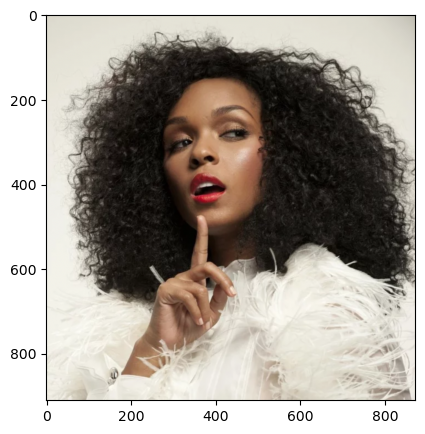

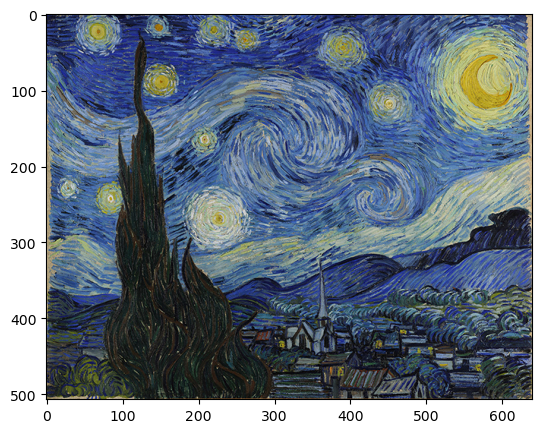

In [322]:
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)

show(content_img)
show(style_img)

In [323]:
def pool_(model, pool='avg'):
    if pool == 'avg':
        ct=0
        for layer in model.children():
            # layerと nn.MaxPool2dの型の比較
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1

    elif pool=='max':
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                if isinstance(layer, nn.AvgPool2d):
                    model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
    return model

model = copy.deepcopy(vgg.features)
model.to(device)

for param in model.parameters():
    # 更新したいパラメータはTrue
    param.requires_grad = False

In [324]:
mse_loss = torch.nn.MSELoss()

def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss  = mse_loss(g, c)
    return loss

def style_loss(g, s):
    c1, c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2)

def tv_loss(c):
    x = c[:, :, 1:, :] - c[:,:,:-1,:]
    y = c[:, :, :, 1:] - c[:, :, :, :-1]
    loss = torch.sum(torch.abs(x) + torch.sum(torch.abs(y)))
    return loss


In [325]:
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
    }

    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if name=='22':
                features[layers[name]] = x
            elif name=='31':
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)

            if name=='35':
                break

    return features

In [326]:
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if init_image=='random':
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()

    return tensor

content_tensor = itot(content_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)

In [327]:
def stylize(iteration=NUM_ITER):
    # TODO 検証
    # content_layers = ['relu3_2']
    content_layers = ['relu4_2']
    # 0 - 1.0 重みを1.0以上にすると発散する
    # content_weights = {'relu3_2': 1.0}
    content_weights = {'relu4_2': 1.0} 

    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    
    # vgg19 の構造
    # https://jp.mathworks.com/help/deeplearning/ref/vgg19.html
    
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)
    # print(f"get_features:c_feat>>> {c_feat}")
    # print(f"get_features:s_feat>>> {s_feat}")

    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                # content_loss return mse_loss(arg1, arg2)
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            
            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)

    return g

Style Loss: 63067212.0 Content Loss: 1237537.75 TV Loss: 636731.6875 Total Loss : 64941480.0


Style Loss: 271988.34375 Content Loss: 877438.0625 TV Loss: 11480526848.0 Total Loss : 11481675776.0


Style Loss: 206792.359375 Content Loss: 710194.5 TV Loss: 11518915584.0 Total Loss : 11519832064.0


Style Loss: 175960.25 Content Loss: 671851.1875 TV Loss: 11665775616.0 Total Loss : 11666623488.0


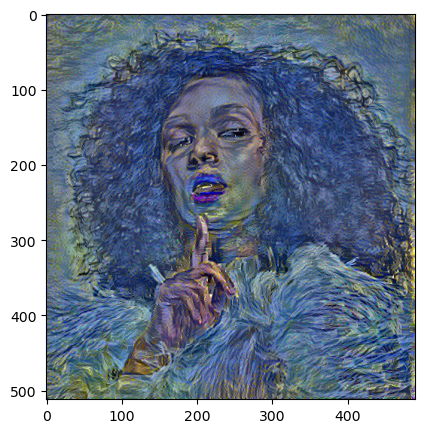

Style Loss: 199312.71875 Content Loss: 659867.0 TV Loss: 11921714176.0 Total Loss : 11922573312.0


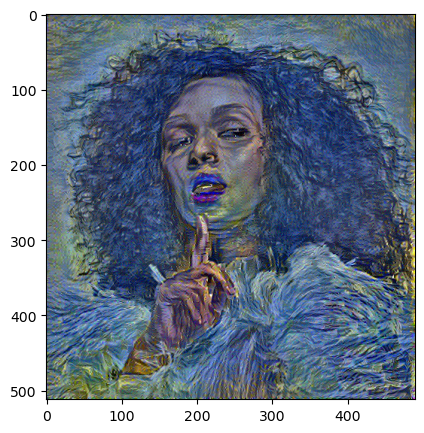

Style Loss: 105126.65625 Content Loss: 605573.5 TV Loss: 11988783104.0 Total Loss : 11989493760.0


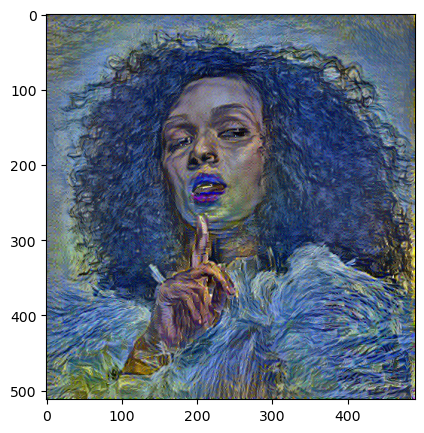

CPU times: user 27.9 s, sys: 11.5 s, total: 39.3 s
Wall time: 2min 19s


In [328]:
%%time
"""
Define Optimizer
The optimizer minimizes the total loss by updating the tensor 'g'.
"""

if (OPTIMIZER=='lbfgs'):
    optimizer = optim.LBFGS([g])
else:
    optimizer = optim.Adam([g], lr=ADAM_LR)

# Stylize!
out = stylize(iteration=NUM_ITER)

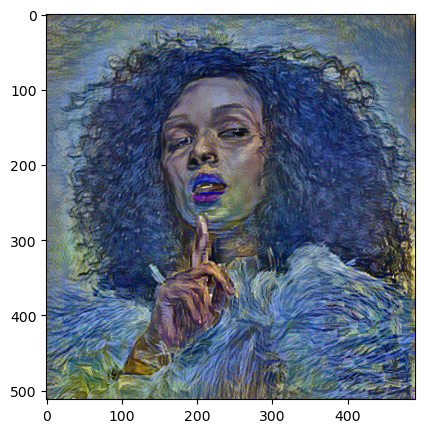

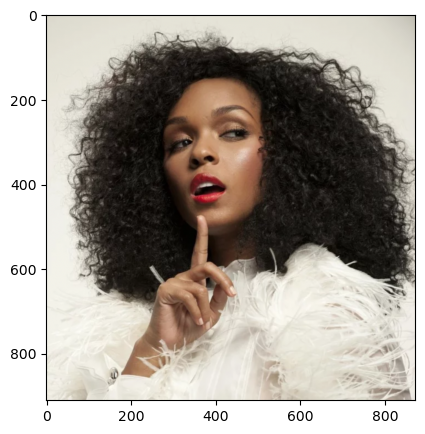

In [329]:
# Save the final output
show(ttoi(g.clone().detach()))
show(content_img)
saveimg(ttoi(g.clone().detach()), NUM_ITER)

if (PRESERVE_COLOR=='True'):
    c_clone = ttoi(content_tensor.clone().detach())
    g_clone = ttoi(g.clone().detach())
    g_preserve = transfer_color(c_clone, g_clone) # Style Transfer + Preserve original color
    show(g_preserve)
    saveimg(g_preserve, 333) # out333 = final with preseved colors